# Pairwise MLP approach

Get tracksters from a certain neighbourhood.

Train a NN to decide whether two tracksters should be joined.

Neighbourhood:
- get links from ticlNtuplizer/graph
- convert the tracksters into some latent space and predict a link between them

Graph:
- linked_inners
    - nodes linked to the given tracksters within its cone


## MLP

In [1]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from reco.training import precision_recall_curve, roc_auc

from torch.utils.data import random_split, DataLoader
from reco.loss import QualityFocalLoss

from reco.datasetPU import TracksterPairs


ds_name = "CloseByTwoPion"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"

# data_root = "/mnt/ceph/users/ecuba/processed"
# raw_dir = f"/mnt/ceph/users/ecuba/{ds_name}"

# writer = SummaryWriter()

In [2]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
ds = TracksterPairs(
    ds_name,
    data_root,
    raw_dir,
    N_FILES=30,
    radius=30,
    bigT_e_th=75,
)

ds.x.shape

torch.Size([111969, 63])

In [4]:
print(ds.x.shape)
print("Positive:", int((ds.y >= 0.5).type(torch.int).sum()))
print("Negative:", int((ds.y < 0.5).type(torch.int).sum()))

torch.Size([111969, 63])
Positive: 69458
Negative: 42511


In [5]:
balance =  float(sum(ds.y > 0.5) / len(ds.y))
print("dataset balance:", balance) 

dataset balance: 0.6203324198722839


In [6]:
ds_size = len(ds)
test_set_size = ds_size // 10
train_set_size = ds_size - test_set_size
train_set, test_set = random_split(ds, [train_set_size, test_set_size])
print(f"Train samples: {len(train_set)}, Test samples: {len(test_set)}")

train_dl = DataLoader(train_set, batch_size=64, shuffle=True)
test_dl = DataLoader(test_set, batch_size=64, shuffle=True)

Train samples: 100773, Test samples: 11196


In [7]:
loss_obj = QualityFocalLoss(gamma=2)

def train(model, opt, loader, loss_obj):
    epoch_loss = 0
    for batch, labels in loader:
        # reset optimizer and enable training mode
        opt.zero_grad()
        model.train()

        # move data to the device
        batch = batch.to(device)
        labels = labels.to(device)
        
        # get the prediction tensor
        z = model(batch).reshape(-1)

        # compute the loss
        loss = loss_obj(z, labels)        
        epoch_loss += loss

        # back-propagate and update the weight
        loss.backward()
        opt.step()

    return float(epoch_loss)

@torch.no_grad()
def test(model, data):
    total = 0
    correct = 0
    for batch, labels in data:
        model.eval()
        batch = batch.to(device)
        labels = labels.to(device)
        z = model(batch).reshape(-1)
        prediction = (z > 0.5).type(torch.int)
        total += len(prediction) 
        correct += sum(prediction == (labels > 0.5).type(torch.int))
    return (correct / total)

In [8]:
hdim1 = 256
hdim2 = 128

model = nn.Sequential(
    nn.LayerNorm(ds.x.shape[1]),      # normalization as a part of the network
    nn.Linear(ds.x.shape[1], hdim1),
    nn.Sigmoid(),
    nn.Linear(hdim1, hdim2),
    nn.Sigmoid(),
    nn.Linear(hdim2, 1),
    nn.Dropout(p=0.2),
    nn.Sigmoid()
).to(device)

epochs = 50
model_path = f"models/PairWiseMLP.QFL.{hdim1}.{hdim2}.{epochs}e-{ds_name}.{ds.RADIUS}r.{ds.bigT_e_th}eth.{ds.N_FILES}f.pt"

In [9]:
#%%script echo skipping
model.load_state_dict(torch.load(
    model_path,
    map_location=device
))
model = model.to(device)

In [10]:
%%script echo skipping
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=1e-5)
loss_obj = QualityFocalLoss(gamma=2)

for epoch in range(epochs):
    loss = train(model, optimizer, train_dl, loss_obj)
    train_auc = roc_auc(model, device, train_dl)
    test_auc = roc_auc(model, device, test_dl)
    scheduler.step()
    if epoch % 5 == 0:
        print(f'Epoch: {epoch}, loss: {loss:.4f}, train auc: {train_auc:.4f}, test auc: {test_auc:.4f}')

torch.save(model.state_dict(), model_path)

skipping


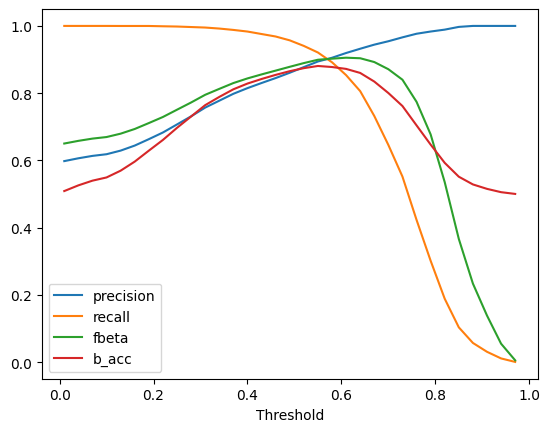

TP: 5675, TN: 4052, FP: 497, FN: 972
TH: 0.61 precision: 0.919 recall: 0.854 fbeta: 0.906 b_acc: 0.872


In [11]:
#%%script echo skipping
precision_recall_curve(model, device, test_dl, focus_metric="fbeta", beta=0.5, step=3)

# Evaluation

Give the model a list of candidate edges to evaluate.
Reconstruct the event and evaluate against ground truth. 

In [13]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
from reco.data import get_event_data
from reco.evaluation import model_evaluation

from reco.dummy import DummyPleaser

file_name = f"{raw_dir}/new_ntuples_15101852_0.root"
cluster_data, trackster_data, simtrackster_data, assoc_data = get_event_data(file_name)

In [16]:
r_ranges = range(5, 45, 5)
results = []

clue3D_F = []
target_F = []
naive_reco_F = []
model_reco_F = []

max_events = 20

for r in r_ranges:
    print(f" --- Radius threshold: {r} ---")
    result = model_evaluation(
        cluster_data,
        trackster_data,
        simtrackster_data,
        assoc_data,
        DummyPleaser(),
        decision_th=0.5,
        radius=r,
        max_events=max_events,
        reco_to_target=False,
        bigT_e_th=75,
    )
    clue3D_F.append(np.sum(np.array(result["clue3d_to_sim"])[:,2]) / max_events)
    target_F.append(np.sum(np.array(result["target_to_sim"])[:,2]) / max_events)
    naive_reco_F.append(np.sum(np.array(result["reco_to_sim"])[:,2]) / max_events)

    result = model_evaluation(
        cluster_data,
        trackster_data,
        simtrackster_data,
        assoc_data,
        model,
        decision_th=0.5,
        radius=r,
        max_events=20,
        reco_to_target=False,
        bigT_e_th=75,
    )
    model_reco_F.append(np.sum(np.array(result["reco_to_sim"])[:,2]) / max_events)

 --- Radius threshold: 35 ---
Event 0:
	clue3d_to_sim:	P: 0.988 R: 0.229 F: 0.594
	target_to_sim:	P: 0.981 R: 0.638 F: 0.886
	reco_to_sim:	P: 0.590 R: 0.677 F: 0.606
Event 1:
	No data
Event 2:
	clue3d_to_sim:	P: 1.000 R: 0.396 F: 0.766
	target_to_sim:	P: 0.999 R: 0.814 F: 0.956
	reco_to_sim:	P: 0.720 R: 0.620 F: 0.698
Event 3:
	clue3d_to_sim:	P: 0.995 R: 0.383 F: 0.754
	target_to_sim:	P: 0.992 R: 0.784 F: 0.942
	reco_to_sim:	P: 0.631 R: 0.792 F: 0.658
Event 4:
	clue3d_to_sim:	P: 0.998 R: 0.250 F: 0.625
	target_to_sim:	P: 0.995 R: 0.836 F: 0.958
	reco_to_sim:	P: 0.544 R: 0.842 F: 0.586
Event 5:
	clue3d_to_sim:	P: 0.996 R: 0.551 F: 0.858
	target_to_sim:	P: 0.995 R: 0.831 F: 0.957
	reco_to_sim:	P: 0.588 R: 0.844 F: 0.626
Event 6:
	clue3d_to_sim:	P: 0.992 R: 0.219 F: 0.582
	target_to_sim:	P: 0.992 R: 0.704 F: 0.917
	reco_to_sim:	P: 0.867 R: 0.717 F: 0.832
Event 7:
	No data
Event 8:
	clue3d_to_sim:	P: 0.997 R: 0.413 F: 0.777
	target_to_sim:	P: 0.996 R: 0.755 F: 0.936
	reco_to_sim:	P: 0.579 

In [17]:
max(np.array(model_reco_F) - np.array(clue3D_F))

0.22329784043270595

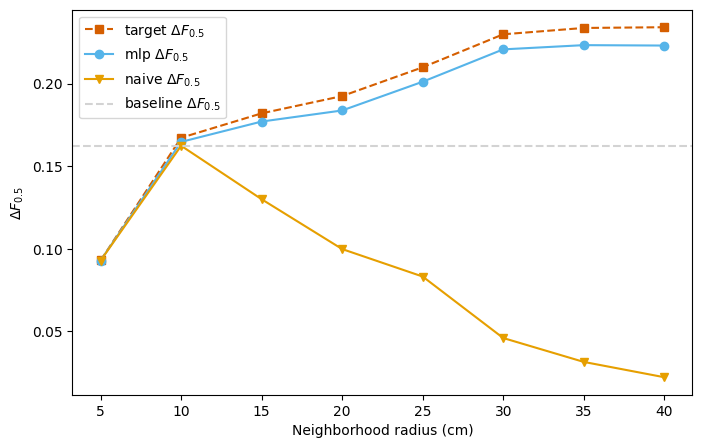

In [27]:
fig = plt.figure(figsize=(8, 5))

ax = fig.add_subplot(111)

ax.plot(r_ranges, np.array(target_F) - np.array(clue3D_F), '--s', label="target $\Delta F_{0.5}$", c="#D55E00")
ax.plot(r_ranges, np.array(model_reco_F) - np.array(clue3D_F), '-o', label="mlp $\Delta F_{0.5}$", c="#56B4E9")
ax.plot(r_ranges, np.array(naive_reco_F) - np.array(clue3D_F), '-v', label="naive $\Delta F_{0.5}$", c="#E69F00")

ax.axhline(max(np.array(naive_reco_F) - np.array(clue3D_F)), label="baseline $\Delta F_{0.5}$", c="lightgray", linestyle="--")

ax.legend()
ax.set_xlabel("Neighborhood radius (cm)")
ax.set_ylabel("$\Delta F_{0.5}$")

fig.savefig('export/two-pions-radius-plot.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [14]:
eth_ranges = range(0, 110, 10)
r_ranges = range(10, 40, 10)
eth_results = []

max_events = 10

for r in r_ranges:
    _clue3D_F = []
    _target_F = []
    for eth in eth_ranges:
        print(f" --- Radius threshold: {r} | Eth: {eth} ---")
        result = model_evaluation(
            cluster_data,
            trackster_data,
            simtrackster_data,
            assoc_data,
            DummyPleaser(),
            decision_th=0.5,
            radius=r,
            max_events=max_events,
            bigT_e_th=eth,
            reco_eval=False
            
        )
        _clue3D_F.append(np.sum(np.array(result["clue3d_to_sim"])[:,2]) / max_events)
        _target_F.append(np.sum(np.array(result["target_to_sim"])[:,2]) / max_events)
    eth_results.append(np.array(_target_F) - np.array(_clue3D_F))

 --- Radius threshold: 10 ---
Event 0:
	clue3d_to_sim:	P: 0.988 R: 0.229 F: 0.594
	target_to_sim:	P: 0.981 R: 0.413 F: 0.770
Event 1:
	clue3d_to_sim:	P: 1.000 R: 0.283 F: 0.664
	target_to_sim:	P: 1.000 R: 0.649 F: 0.903
Event 2:
	clue3d_to_sim:	P: 1.000 R: 0.396 F: 0.766
	target_to_sim:	P: 1.000 R: 0.792 F: 0.950
Event 3:
	clue3d_to_sim:	P: 0.995 R: 0.383 F: 0.754
	target_to_sim:	P: 0.992 R: 0.676 F: 0.907
Event 4:
	clue3d_to_sim:	P: 0.998 R: 0.250 F: 0.625
	target_to_sim:	P: 0.997 R: 0.657 F: 0.903
Event 5:
	clue3d_to_sim:	P: 0.996 R: 0.551 F: 0.858
	target_to_sim:	P: 0.995 R: 0.826 F: 0.956
Event 6:
	clue3d_to_sim:	P: 0.992 R: 0.219 F: 0.582
	target_to_sim:	P: 0.992 R: 0.727 F: 0.925
Event 7:
	clue3d_to_sim:	P: 0.974 R: 0.112 F: 0.385
	target_to_sim:	P: 0.968 R: 0.216 F: 0.571
Event 8:
	clue3d_to_sim:	P: 0.997 R: 0.413 F: 0.777
	target_to_sim:	P: 0.996 R: 0.755 F: 0.936
Event 9:
	clue3d_to_sim:	P: 0.998 R: 0.177 F: 0.518
	target_to_sim:	P: 0.998 R: 0.475 F: 0.818
-----
mean clue3d_to

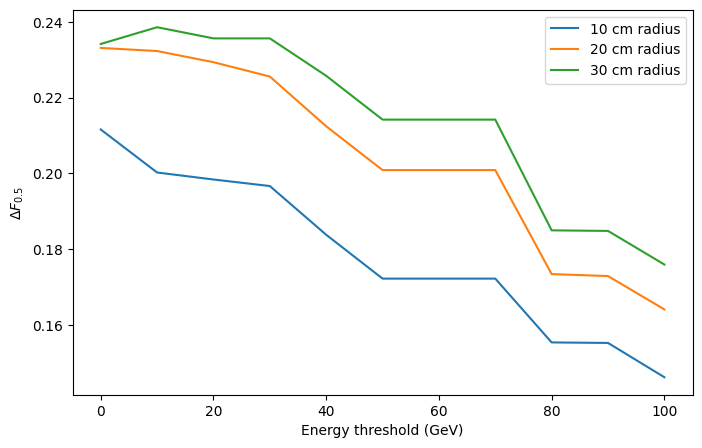

In [16]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

for r, res in zip(r_ranges, eth_results):
    ax.plot(eth_ranges, res, label=f"{r} cm radius")

ax.legend()
ax.set_xlabel("Energy threshold (GeV)")
ax.set_ylabel("$\Delta F_{0.5}$")

fig.savefig('export/two-pions-energy-plot.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [17]:
max(eth_results[2])

0.23861574066868696